In [15]:
# Imports
%load_ext autoreload
%autoreload 2

import json
import math
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import os
import random
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
from tqdm import tqdm
import sys

from astropy.coordinates import Distance
import bilby

# Add module
sys.path.append('../../modules')
from bilby.gw.prior import AlignedSpin
from compute_omega import sample_dict_compute_injected_omega
from gwBackground_module import *
import lal
lal.swig_redirect_standard_output_error(False)
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator

from constants import *
import equations
import redshiftPrior

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Plot formatting
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize': fontsize,
   'lines.linewidth': 1,  
   'xtick.direction': 'in',
   'ytick.direction': 'in',
   'font.family': 'Serif',
   'font.serif': 'Hoefler Text',
   'axes.grid': True,
   'figure.figsize': (6.75, 4),
   'figure.dpi': 250,
   'mathtext.fontset': 'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]  

In [3]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Data Simulation Parameters
T_obs = (10/365.25) # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
fs = 2048 # sampling rate (in Hz)

num_iterations = 50

In [4]:
class SpinPrior(bilby.core.prior.Prior):
    '''
    Realistic spin distribution probabilities from Callister and Farr
    ''' 
    def __init__(self, minimum, maximum, **kwargs):
        self.minimum = minimum
        self.maximum = maximum
        super(SpinPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)

    def prob(self, chi):
        chi0 = 0.15
        gamma = 0.18
        f_iso = 0.67
        mu = 0.59
        sigma = 0.58
        
        C = (math.atan((1-chi0)/gamma) + math.atan(chi0/gamma))**(-1)
        pchi = (C/gamma)*(1+((chi-chi0)/gamma)**2)**(-1)
        return pchi
        
    def _get_chi_arrays(self):
        chi0 = 0.15
        gamma = 0.18
        f_iso = 0.67
        mu = 0.59
        sigma = 0.58

        chis = np.linspace(self.minimum, self.maximum, 1000)
        pchis = self.prob(chis)
        return chis, pchis

    def sample(self, size):
        chis, pchis = self._get_chi_arrays()
        max_pchi = np.max(pchis)
        total = 0
        samples = []
        # a = []
        # b = []
        # c = []
        # d = []
        while total < size:
            chiIndex = random.randint(1000)
            chi = chis[chiIndex]
            pchi = random.rand()*max_pchi
            if(pchi < pchis[chiIndex]):
                samples.append(chi)
                total = total + 1
        #         a.append(chi)
        #         b.append(pchi)
        #     else:
        #         c.append(chi)
        #         d.append(pchi)
        # fig, ax = plt.subplots()
        # ax.scatter(a, b, s=0.5, color='g')
        # ax.scatter(c, d, s=0.5, color='r')
        # ax.plot(chis, pchis, color='b')
        # ax.set_title(r'Rejection Sampling for $\chi$ (N = 10000)')
        # ax.set_xlabel(r'$\chi$')
        # ax.set_ylabel(r'$p(\chi)$')
        return np.array(samples)
    
class ThetaPrior(bilby.core.prior.Prior):
    '''
    Theta distribution prior from Callister and Farr
    '''
    chi0 = 0.15
    gamma = 0.18
    f_iso = 0.67
    mu = 0.59
    sigma = 0.58

    def __init__(self, minimum, maximum, **kwargs):
        self.minimum = minimum
        self.maximum = maximum
        super(ThetaPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)

    def phi(self, xi):
            return (1/math.sqrt(2*math.pi))*math.exp(-(1/2)*xi**2)
    
    def Phi(self, x):
            return (1/2)*(1+math.erf(x/math.sqrt(2)))

    def prob(self, costheta):
        a = self.minimum
        b = self.maximum

        Nab = (1/self.sigma)*(self.phi((costheta-self.mu)/self.sigma))/(self.Phi((b - self.mu)/self.sigma) - self.Phi((a - self.mu)/self.sigma))
        pcostheta = self.f_iso/2 + (1 - self.f_iso)*Nab
        return pcostheta
        
    def _get_costheta_arrays(self):
        costhetas = np.linspace(self.minimum, self.maximum, 1000)
        pcosthetas = []
        for costheta in costhetas:
            pcostheta = self.prob(costheta)
            pcosthetas.append(pcostheta)
        return costhetas, pcosthetas
    
    def sample(self, size):
        costhetas, pcosthetas = self._get_costheta_arrays()
        max_pcostheta = np.max(pcosthetas)
        total = 0
        samples = []
        # a = []
        # b = []
        # c = []
        # d = []
        while total < size:
            costhetaIndex = random.randint(1000)
            costheta = costhetas[costhetaIndex]
            theta = math.acos(costheta)
            pcostheta = random.rand()*max_pcostheta
            if(pcostheta < pcosthetas[costhetaIndex]):
                # samples.append(costheta)
                samples.append(theta)
                total = total + 1
        #         a.append(costheta)
        #         b.append(pcostheta)
        #     else:
        #         c.append(costheta)
        #         d.append(pcostheta)
        # fig, ax = plt.subplots()
        # ax.scatter(a, b, s=0.5, color='g')
        # ax.scatter(c, d, s=0.5, color='r')
        # ax.plot(costhetas, pcosthetas, color='b')
        # ax.set_title(r'Rejection Sampling for cos$(\theta)$ (N = 10000)')
        # ax.set_xlabel(r'cos$(\theta)$')
        # ax.set_ylabel(r'$p$'+'(cos'+r'$(\theta)$)')
        return np.array(samples)

In [5]:
test = SpinPrior(minimum=0, maximum=1, name='a_1')
samples = test.sample(10000)
chis, pchis = test._get_chi_arrays()

test = ThetaPrior(minimum=-1, maximum=1, name='tilt_1')
samples = test.sample(10000)
costhetas, pcosthetas = test._get_costheta_arrays()

# Check distribution
# fig, ax = plt.subplots()
# ax.hist(samples, color='black')
# ax.plot(chis,pchis*200, color='red')
# ax.set_xlim(0,1)

In [6]:
# Standard Prior Dictionary
# priors_none = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# priors_none['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
# priors_none['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
# priors_none['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
# priors_none['a_1'] = 0
# priors_none['a_2'] = 0
# priors_none['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
# priors_none['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
# del priors_none['luminosity_distance']
# del priors_none['chirp_mass']

# priors_uniform = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# priors_uniform['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
# priors_uniform['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
# priors_uniform['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
# priors_uniform['a_1'] = bilby.core.prior.Uniform(minimum=-1, maximum=1)
# priors_uniform['a_2'] = bilby.core.prior.Uniform(minimum=-1, maximum=1)
# priors_uniform['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
# priors_uniform['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
# del priors_uniform['luminosity_distance']
# del priors_uniform['chirp_mass']

# priors_aligned = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# priors_aligned['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
# priors_aligned['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
# priors_aligned['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
# priors_aligned['a_1'] = bilby.gw.prior.AlignedSpin()
# priors_aligned['a_2'] = bilby.gw.prior.AlignedSpin()
# priors_aligned['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
# priors_aligned['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
# del priors_aligned['luminosity_distance']
# del priors_aligned['chirp_mass']

# priors_spin = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# priors_spin['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
# priors_spin['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
# priors_spin['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
# priors_spin['a_1'] = SpinPrior(minimum=0, maximum=1, name='a_1')
# priors_spin['a_2'] = SpinPrior(minimum=0, maximum=1, name='a_2')
# priors_spin['tilt_1'] = ThetaPrior(minimum=-1, maximum=1, name='cos_tilt_1')
# priors_spin['tilt_2'] = ThetaPrior(minimum=-1, maximum=1, name='cos_tilt_2')
# priors_spin['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
# priors_spin['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
# del priors_spin['luminosity_distance']
# del priors_spin['chirp_mass']

priors = bilby.gw.prior.BBHPriorDict()
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors['mass_2'] = 0
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['a_1'] = 0
priors['a_2'] = 0
priors['phi_12'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='phi_12')
priors['phi_jl'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='phi_jl')
priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors['luminosity_distance']
del priors['chirp_mass']

01:47 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [7]:
# Calculate number of injections
def calculate_num_injections(T_obs, priors):
    zs, p_dz = priors['redshift']._get_redshift_arrays()
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs) * p_dz_centers)
    N = T_obs * total_sum
    print(p_dz)
    return N

zs, p_dz = priors['redshift']._get_redshift_arrays()
N = calculate_num_injections(T_obs, priors)
print(N)

[  0.           3.18473004  12.8720701  ... 457.38880608
 455.14080154 452.90572928] 1 / yr
6583.533970255626 1 / yr


In [8]:
# Save injections
# injections_list = []
# N_inj = np.random.poisson(N.value)
# for i in range(num_iterations):
#     injections = priors.sample(N_inj)
#     # Convert from source frame to detector frame masses
#     injections['mass_2'] = (injections['mass_1']*injections['mass_ratio'])*(1 + injections['redshift'])
#     injections['mass_1'] = injections['mass_1']*(1 + injections['redshift'])
#     injections["signal_type"] = "CBC"
#     injections_list.append(injections)

# Convert from source frame to detector frame masses
# for i in range(len(injections_list)):
#     injections = injections_list[i]
#     for j in range(len(injections['mass_1'])):
#         injections['mass_2'][j] = (injections['mass_1'][j]*injections['mass_ratio'][j])*(1 + injections['redshift'][j])
#         injections['mass_1'][j] = injections['mass_1'][j]*(1 + injections['redshift'][j])
        
def json_serialize(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

# injections_list_json = json.dumps(injections_list, default=json_serialize)
# with open("injections1.json", "w") as outfile:
#     json.dump(injections_list_json, outfile)

# Open injections for next use
f = open('injections1.json')
injections_list = json.load(f)
injections_list = json.loads(injections_list)
f.close()

# Define spin distribution and replace temporary sampling
# No spin
# for i in range(len(injections_list)):
#     injections = injections_list[i]
#     for j in range(len(injections['a_1'])):
#         injections['a_1'][j] = 0
#     for j in range(len(injections['a_2'])):
#         injections['a_2'][j] = 0

# Uniform
# priors['a_1'] = bilby.core.prior.Uniform(minimum=0, maximum=1)
# priors['a_2'] = bilby.core.prior.Uniform(minimum=0, maximum=1)
# for i in range(len(injections_list)):
#     injections = injections_list[i]
#     injections['a_1'] = priors['a_1'].sample(len(injections['a_1']))
#     injections['a_2'] = priors['a_2'].sample(len(injections['a_2']))

# Callister and Farr distribution
# priors['a_1'] = SpinPrior(minimum=0, maximum=1, name='a_1')
# priors['a_2'] = SpinPrior(minimum=0, maximum=1, name='a_2')
# priors['tilt_1'] = ThetaPrior(minimum=-1, maximum=1, name='tilt_1')
# priors['tilt_2'] = ThetaPrior(minimum=-1, maximum=1, name='tilt_2')
# injections['a_1'] = priors['a_1'].sample(len(injections))
# injections['a_2'] = priors['a_2'].sample(len(injections))
# injections['tilt_1'] = priors['tilt_1'].sample(len(injections))
# injections['tilt_2'] = priors['tilt_2'].sample(len(injections))

# High Spin Magnitude
# for i in range(len(injections_list)):
#     injections = injections_list[i]
#     for j in range(len(injections['a_1'])):
#         injections['a_1'][j] = 1
#     for j in range(len(injections['a_2'])):
#         injections['a_2'][j] = 1

# High Spin Magnitude with Truncated Gaussian
# priors['a_1'] = bilby.core.prior.analytical.TruncatedGaussian(mu=1, sigma=0.5, minimum=0, maximum=1)
# priors['a_2'] = bilby.core.prior.analytical.TruncatedGaussian(mu=1, sigma=0.5, minimum=0, maximum=1)
# for i in range(len(injections_list)):
#     injections = injections_list[i]
#     injections['a_1'] = priors['a_1'].sample(len(injections['a_1']))
#     injections['a_2'] = priors['a_2'].sample(len(injections['a_2']))
    
# Low Spin Magnitude with Truncated Gaussian
priors['a_1'] = bilby.core.prior.analytical.TruncatedGaussian(mu=0, sigma=0.5, minimum=0, maximum=1)
priors['a_2'] = bilby.core.prior.analytical.TruncatedGaussian(mu=0, sigma=0.5, minimum=0, maximum=1)
for i in range(len(injections_list)):
    injections = injections_list[i]
    injections['a_1'] = priors['a_1'].sample(len(injections['a_1']))
    injections['a_2'] = priors['a_2'].sample(len(injections['a_2']))

# Aligned Spins
# for i in range(len(injections_list)):
#     injections = injections_list[i]
#     for j in range(len(injections['tilt_1'])):
#         injections['tilt_1'][j] = 0
#     for j in range(len(injections['tilt_2'])):
#         injections['tilt_2'][j] = 0

# Anti-Aligned Spins
for i in range(len(injections_list)):
    injections = injections_list[i]
    for j in range(len(injections['tilt_1'])):
        injections['tilt_1'][j] = math.pi
    for j in range(len(injections['tilt_2'])):
        injections['tilt_2'][j] = math.pi

# In-Plane
# for i in range(len(injections_list)):
#     injections = injections_list[i]
#     for j in range(len(injections['tilt_1'])):
#         injections['tilt_1'][j] = math.pi/2
#     for j in range(len(injections['tilt_2'])):
#         injections['tilt_2'][j] = math.pi/2

In [9]:
# Plot Distribution
# Uniform Distribution
# fig, ax = plt.subplots()
# chi1s = []
# chi2s = []
# probs1 = []
# probs2 = []
# for i in range(0, 100):
#     chi1s.append(i*0.01)
#     chi2s.append(i*0.01)
#     probs1.append(priors_uniform['a_1'].prob(i*0.01))
#     probs2.append(priors_uniform['a_2'].prob(i*0.01))
# ax.plot(chi1s, probs1, color='#ff0000')
# ax.plot(chi2s, probs2, color='#0000ff')

# Aligned Distribution
# fig, ax = plt.subplots()
# chi1s = []
# chi2s = []
# probs1 = []
# probs2 = []
# for i in range(0, 100):
#     chi1s.append(i*0.01)
#     chi2s.append(i*0.01)
#     probs1.append(priors_aligned['a_1'].prob(i*0.01))
#     probs2.append(priors_aligned['a_2'].prob(i*0.01))
# ax.plot(chi1s, probs1, color='#ff0000')
# ax.plot(chi2s, probs2, color='#0000ff')

# Realistic Spin Prior from Callister and Farr
# fig, ax = plt.subplots()
# chi1s = []
# chi2s = []
# probs1 = []
# probs2 = []
# for i in range(0, 100):
#     chi1s.append(i*0.01)
#     chi2s.append(i*0.01)
#     probs1.append(priors_spin['a_1'].prob(i*0.01))
#     probs2.append(priors_spin['a_2'].prob(i*0.01))
# ax.plot(chi1s, probs1, color='#ff0000')
# ax.plot(chi2s, probs2, color='#0000ff')

# Current Distribution
# fig, ax = plt.subplots()
# chi1s = []
# chi2s = []
# probs1 = []
# probs2 = []
# for i in range(0, 100):
#     chi1s.append(i*0.01)
#     chi2s.append(i*0.01)
#     probs1.append(priors['a_1'].prob(i*0.01))
#     probs2.append(priors['a_2'].prob(i*0.01))
# ax.plot(chi1s, probs1, color='#ff0000')
# ax.plot(chi2s, probs2, color='#0000ff')

# p(cos(theta)) Probability Distribution
# fig, ax = plt.subplots()
# costheta1s = []
# costheta2s = []
# probs1 = []
# probs2 = []
# for i in range(-100, 100):
#     costheta1s.append(i*0.01)
#     costheta2s.append(i*0.01)
#     probs1.append(priors['cos_tilt_1'].prob(i*0.01))
#     probs2.append(priors['cos_tilt_2'].prob(i*0.01))
# ax.plot(costheta1s, probs1, color='#ff0000')
# ax.plot(costheta2s, probs2, color='#0000ff')

In [10]:
OmegaGWs = []
for i in range(num_iterations):
    freqs_psd, omega_gw_freq = sample_dict_compute_injected_omega(injections_list[i], Tobs=T_obs, duration=1, f_ref=50, sampling_frequency=2048,
                                       approximant='IMRPhenomXPHM')
    OmegaGWs.append(omega_gw_freq)

freqs_json = json.dumps(freqs_psd, default=json_serialize)
OmegaGW_json = json.dumps(OmegaGWs, default=json_serialize)
with open("omegaGW1_lowTruncatedAntiAligned1.json", "w") as outfile:
    json.dump({"freqs_psd": freqs_json, "OmegaGWs": OmegaGW_json}, outfile)

01:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2024-02-16 01:47:05.955 | INFO     | compute_omega:sample_dict_compute_injected_omega:107 - Compute the total injected Omega for 6442 injections
100%|██████████| 6442/6442 [00:15<00:00, 411.72it/s]
01:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2024-02-16 01:47:21.652 | INFO     | compute_omega:sample_dict_compute_injected_omega:107 - Compute the total injected Omega for 6442 injections
100%|██████████| 6442/6442 [00:15<00:00, 417.27it/s]
01:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal

In [11]:
def find_min_and_max_spectrum(spectra):
    min_value = 1.0
    max_value = 0.0
    min_spectrum = spectra[0]
    max_spectrum = spectra[0]
    for i in range(len(spectra)):
        if max(spectra[i]) < min_value:
            min_value = max(spectra[i])
            min_spectrum = spectra[i]
        if max(spectra[i]) > max_value:
            max_value = max(spectra[i])
            max_spectrum = spectra[i]
    return min_spectrum, max_spectrum

def average_spectra(spectra):
    return np.average(spectra, axis=0)

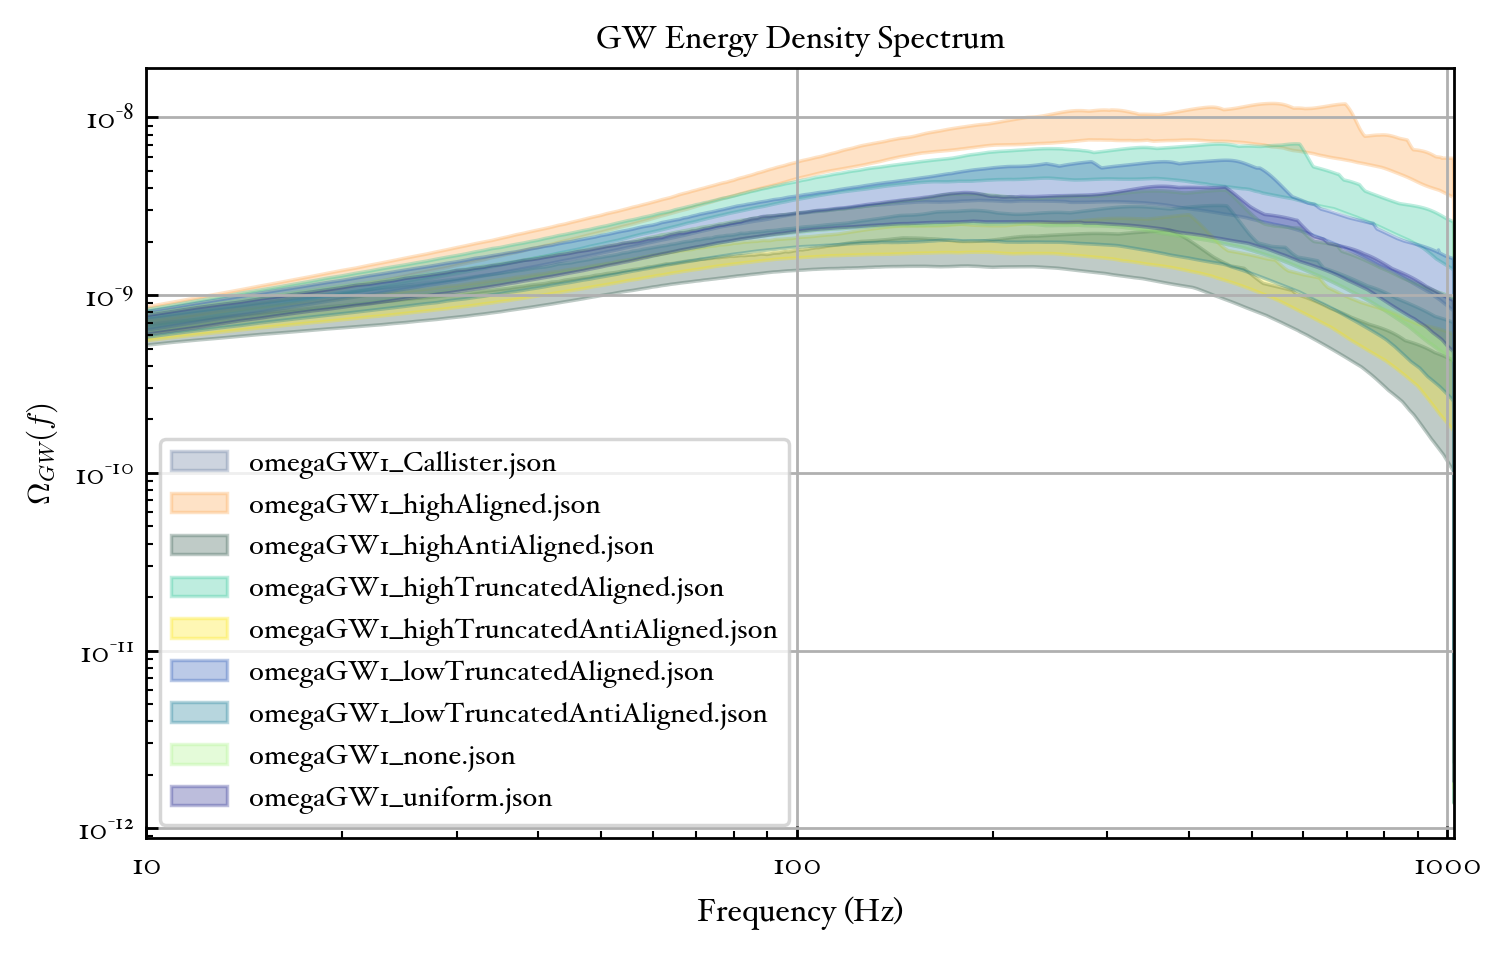

In [19]:
%matplotlib inline
# Read data
file_names = [
                'omegaGW1_Callister.json', 
                'omegaGW1_highAligned.json',
                'omegaGW1_highAntiAligned.json',
                'omegaGW1_highTruncatedAligned.json',
                'omegaGW1_highTruncatedAntiAligned.json',
                'omegaGW1_lowTruncatedAligned.json',
                'omegaGW1_lowTruncatedAntiAligned.json',
                'omegaGW1_none.json',
                'omegaGW1_uniform.json'
            ]

freqs_data = []
OmegaGWs_data = []
for file in file_names:
    f = open(file)
    data = json.load(f)
    freqs_psd = data.get('freqs_psd')
    OmegaGWs = data.get('OmegaGWs')
    freqs_psd = json.loads(freqs_psd)
    OmegaGWs = json.loads(OmegaGWs)
    f.close()
    freqs_data.append(freqs_psd)
    OmegaGWs_data.append(OmegaGWs)

fig, ax = plt.subplots()
# Plot all iterations
# for i in range(num_iterations):
    # ax.loglog(freqs_psd, OmegaGWs[i], color='#ffff00')

# Plot minimum and maximum spectra
# min_value, max_value = find_min_and_max_spectrum(OmegaGWs)
# ax.fill_between(freqs_psd, min_value, max_value, color='#ffff00', alpha=0.3)

# Plot average spectrum
# ax.loglog(freqs_psd, average_spectra(OmegaGWs), color='#0000ff')

# Plot 5th and 95th percentiles
for i in range(len(OmegaGWs_data)):
    ax.fill_between(freqs_data[i], np.percentile(OmegaGWs_data[i], 5, axis=0), np.percentile(OmegaGWs_data[i], 95, axis=0), color=(random.random(), random.random(), random.random()), label=file_names[i], alpha=0.3)

ax.set_title(r'GW Energy Density Spectrum')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1024)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-10, 1e-8)
ax.legend(loc='lower left')

In [13]:
def findChiEff(chi1, chi2, theta1, theta2, q):
    return (chi1*math.cos(theta1) + q*chi2*math.cos(theta2))/(1 + q)

In [14]:
# # Chi/Chi_eff Distribution
# chi1s = injections['a_1']
# chi2s = injections['a_2']
# costheta1s = injections['cos_tilt_1']
# costheta2s = injections['cos_tilt_2']
# qs = injections['mass_ratio']
# chiEffs = []
# for injection in injections['a_1']:
#     chiEff = (chi1s[i]*costheta1s[i] + qs[i]*chi2s[i]*costheta2s[i])/(1 + qs[i])
#     chiEffs.append(chiEff)

# fig, ax = plt.subplots()
# ax.plot(chi1s, chiEffs, color='#ff0000', label=r'$\a_1$')
# ax.plot(chi2s, chiEffs, color='#0000ff', label=r'$\a_2$')
# ax.set_xlabel(r'$\chi$')
# ax.set_ylabel(r'$\chi_{eff}$')

# fig, ax = plt.subplots()
# ax.hist(chi1s/chiEffs, color='#ff0000', label=r'$\a_1$')
# ax.hist(chi2s/chiEffs, color='#0000ff', label=r'$\a_2$')
# ax.set_xlabel(r'$\chi$')
# ax.set_ylabel(r'$\chi_{eff}$')